In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import glob
from typing import Callable
import itertools
import scipy


<AxesSubplot: >

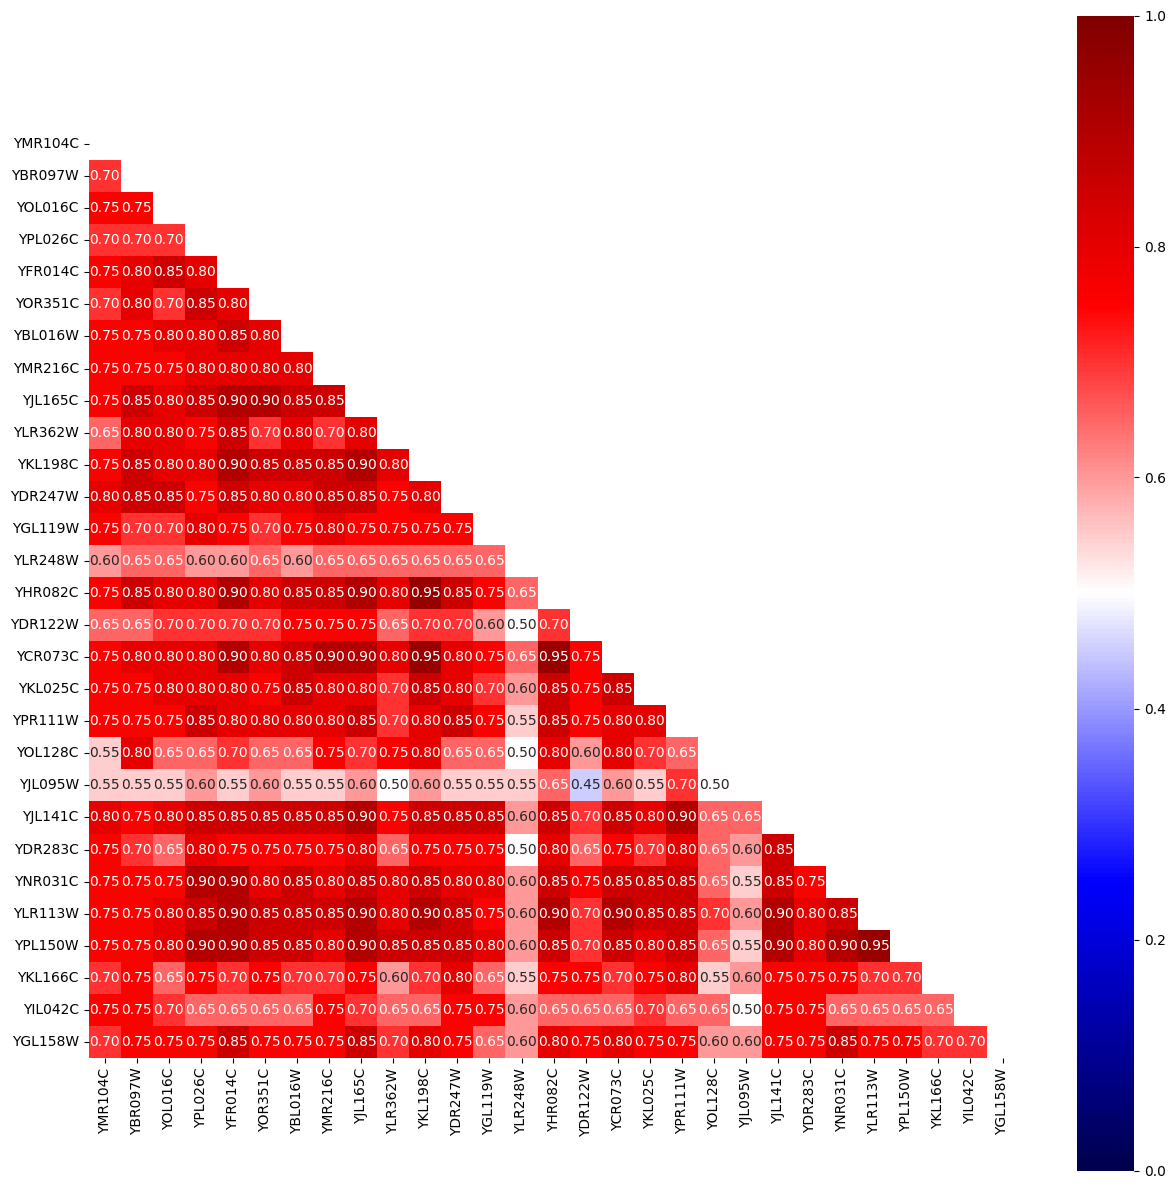

In [3]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def count_overlap(enzymes_one: List, enzymes_two: List):
    return len(set(enzymes_one[:20]) & set(enzymes_two[:20])) / len(enzymes_one[:20])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts


df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
df[df['metabolite_id'] == 'pyr']

correlation_matrix, knockouts = rank_correlation_metabolite_id(df, 'pyr', count_overlap)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(
    correlation_matrix, 
    square=True, 
    annot=True,
    fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
)

In [4]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

In [24]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
df = df[(df['metabolite_id'] == 'pyr') & (df['KO_ORF'] == 'YBL016W')]

with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model_tier_0_all = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

print(f"{type(model_tier_0_metabolite_strategy)}")

base_frame = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

target_enzymes = df['exp_enzymes'].values[0][:10]
lb, ub = -.5, 1.25

<class 'sklearn.compose._target.TransformedTargetRegressor'>


In [41]:
def fitness(genotype):
    _df = base_frame.loc[base_frame['pep'].idxmax()].to_frame().T
    _df[target_enzymes] = genotype

    return np.log(5) - model_tier_0_metabolite_strategy.predict(_df)

bounds = np.repeat(
    [(lb, ub)], len(target_enzymes), axis=0
)

print(bounds.shape)

def print_fn(xk, convergence):
    # print(f"{xk=}")
    return

res = scipy.optimize.differential_evolution(
    func=fitness,
    bounds=bounds,
    strategy='best1bin',
    disp=True,
    seed=20,
    workers=-1,
    maxiter=100,
    popsize=32,
    updating='deferred',
    callback=print_fn,
    init='sobol',
)

(10, 2)
differential_evolution step 1: f(x)= -2.96613
differential_evolution step 2: f(x)= -3.04673
differential_evolution step 3: f(x)= -3.24121
differential_evolution step 4: f(x)= -3.28427
differential_evolution step 5: f(x)= -3.28427
differential_evolution step 6: f(x)= -3.57309
differential_evolution step 7: f(x)= -3.57309
differential_evolution step 8: f(x)= -3.57309
differential_evolution step 9: f(x)= -3.57309
differential_evolution step 10: f(x)= -3.65498
differential_evolution step 11: f(x)= -3.65498
differential_evolution step 12: f(x)= -3.65498
differential_evolution step 13: f(x)= -3.65498
differential_evolution step 14: f(x)= -3.65498
differential_evolution step 15: f(x)= -3.65498
differential_evolution step 16: f(x)= -3.65498
differential_evolution step 17: f(x)= -3.65775
differential_evolution step 18: f(x)= -3.71391
differential_evolution step 19: f(x)= -3.71391
differential_evolution step 20: f(x)= -3.71391
differential_evolution step 21: f(x)= -3.77634
differential_e

In [40]:
res

     fun: -1.456543456081863
     jac: array([-0.07851826,  0.7435732 ,  0.53479416, -0.15780346,  0.37411567,
        0.28736782,  0.30079583, -0.21591857, -0.57292988,  0.        ])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 51734
     nit: 100
 success: False
       x: array([ 1.25      , -0.5       , -0.5       ,  1.25      , -0.5       ,
       -0.5       , -0.5       ,  1.25      ,  1.25      , -0.03562537])